# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [29]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine

# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [9]:
import mysql.connector
from getpass import getpass


In [13]:
#Create a connection with create_engine to MySQL Workbench:

import mysql.connector
from getpass import getpass

password = getpass("Enter your MySQL password: ")

# Connect to MySQL database
try:
    connection = mysql.connector.connect(
        user='root',
        password=password,
        host='localhost',
        database='salescsdata'
    )
    print("Connected to MySQL database successfully!")

    cursor = connection.cursor()


    cursor.execute("SELECT * FROM wholesale_customers_data")
    customers = cursor.fetchall()
    
    sales_cs = pd.DataFrame(customers, columns=[desc[0] for desc in cursor.description])
    

    cursor.close()
    connection.close()
    
except mysql.connector.Error as error:
    print("Failed to connect to MySQL database:", error)


Enter your MySQL password: ········
Connected to MySQL database successfully!


In [14]:
sales_cs.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [16]:
# Your code here:

sales_cs.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [17]:
sales_cs.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [19]:
sales_cs["Channel"].unique()

array([2, 1])

In [20]:
sales_cs["Region"].unique()

array([3, 1, 2])

In [22]:
sales_cs.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000,880.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.467785,0.773832,12640.132660,7376.177813,9497.755624,4851.911072,4765.141586,2818.501325
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


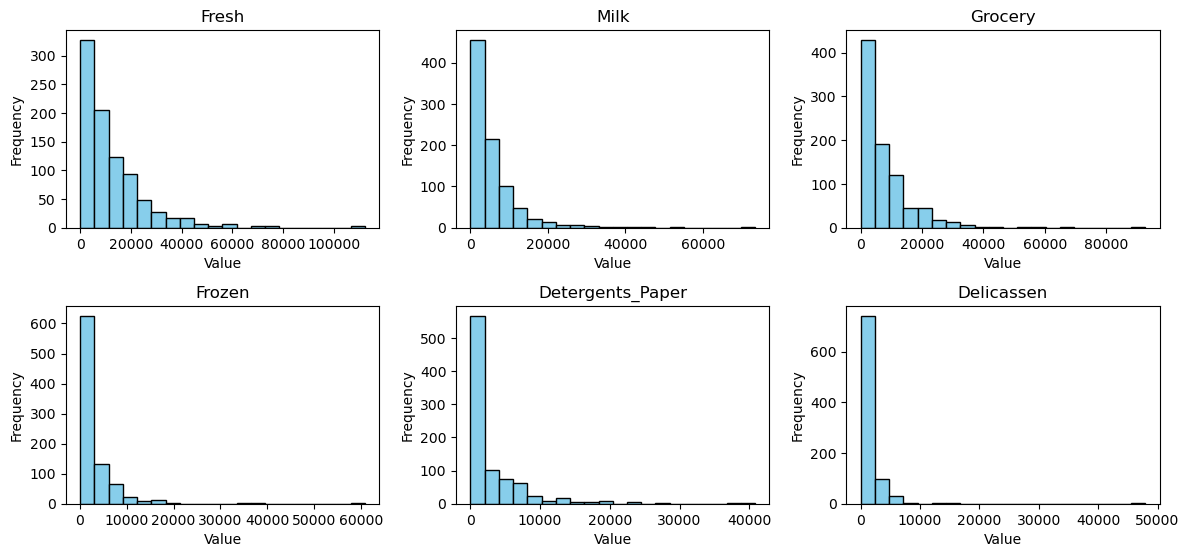

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, column in enumerate(sales_cs.columns[2:]):
    plt.subplot(3, 3, i+1)
    plt.hist(sales_cs[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Your observations here

#Channel = type of customer or distribution channel(retailer, restaurant...)
#Region = where the customer is located 
#Fresh/Milk/Grocery/Frozen/Detergents_Paper/Delicassen = total amount bought by customer for
#different product category

# Data are right skewed (positive skewness). Majority of sales happened for less than the 
#average price. Suggest the presence of outliers.

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [27]:
# Your code here

from sklearn.preprocessing import StandardScaler

columns_to_transform = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

sales_log_transformed = sales_cs.copy()
sales_log_transformed[columns_to_transform] = sales_log_transformed[columns_to_transform].applymap(lambda x: np.log1p(x))

# Normalize the data
scaler = StandardScaler()
# Only transform the columns that have been log transformed
sales_log_transformed[columns_to_transform] = scaler.fit_transform(sales_log_transformed[columns_to_transform])

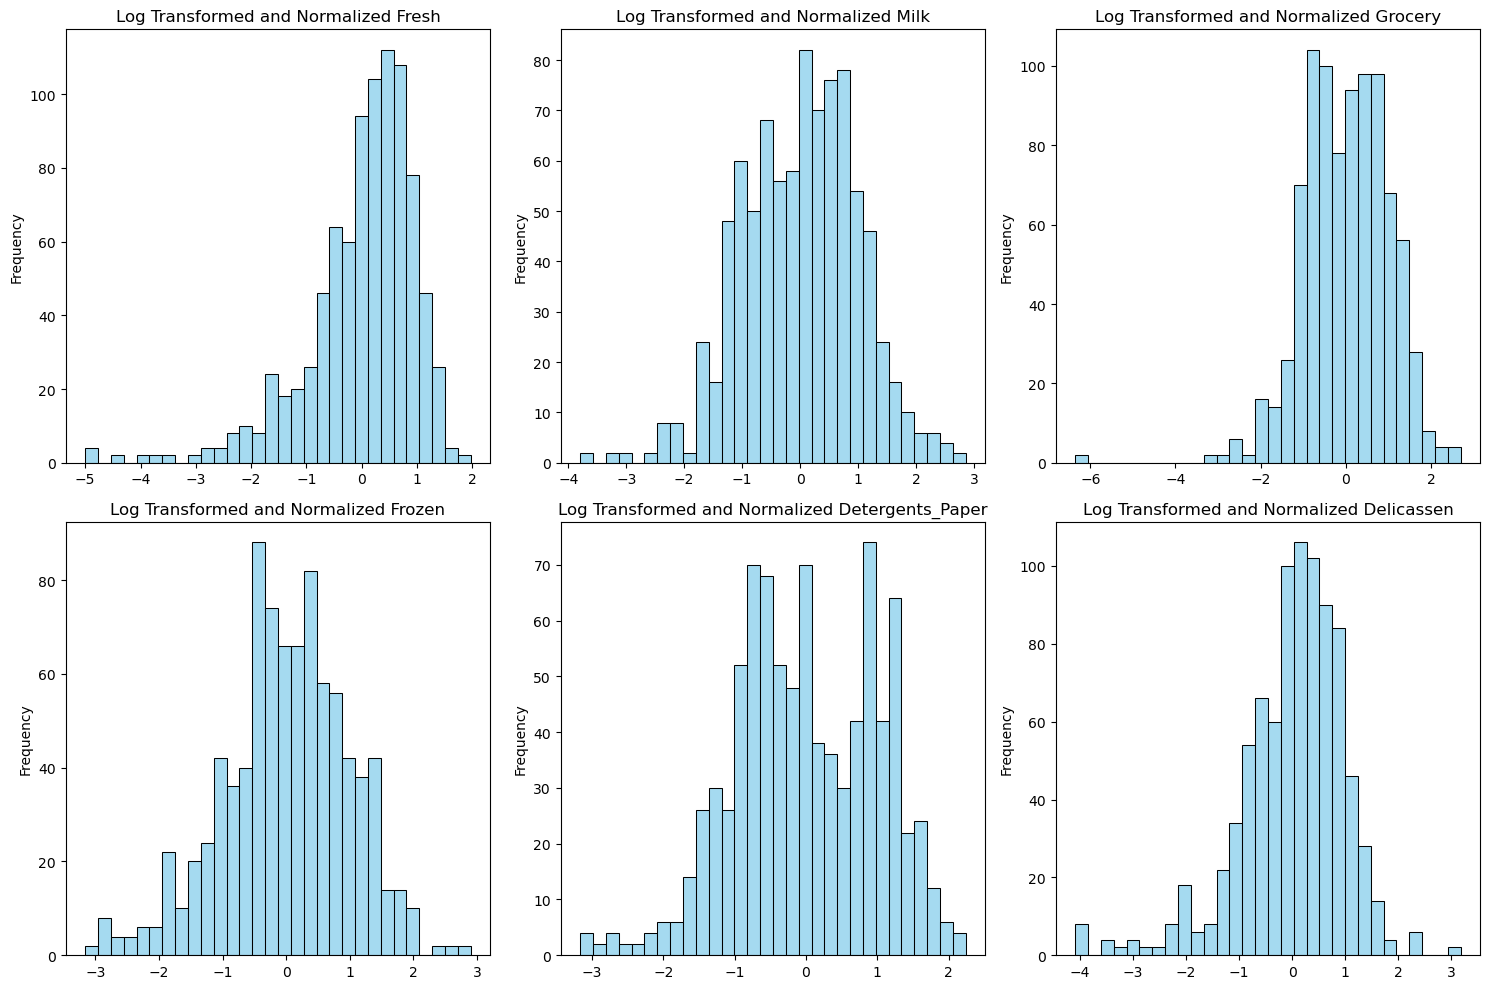

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.flatten() 

for i, col in enumerate(columns_to_transform):
    sns.histplot(sales_log_transformed[col], bins=30, kde=False, ax=axs[i], color='skyblue')
    axs[i].set_title(f'Log Transformed and Normalized {col}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Your comment here

# Date very skewed, we put the logarithmic scale to reduce the influence of outliers.
# Also the scale varies between all categories.
# We have no negative or nan values so we can apply this method. Goal is to reduce the variability of data.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [ ]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:

# Step done in Challenge 2

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [32]:
# Your code here:
from sklearn.cluster import KMeans

sales_log_transformed.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,0.486184,0.976299,0.440155,-1.509250,0.644143,0.408966
1,2,3,0.087889,0.990956,0.652171,0.134052,0.766043,0.627926
2,2,3,0.016356,0.891151,0.454687,0.376899,0.804405,1.776833
3,1,3,0.517477,-0.957973,-0.084792,1.141574,-0.328712,0.633133
4,2,3,0.880631,0.439662,0.395847,0.757322,0.404939,1.456588


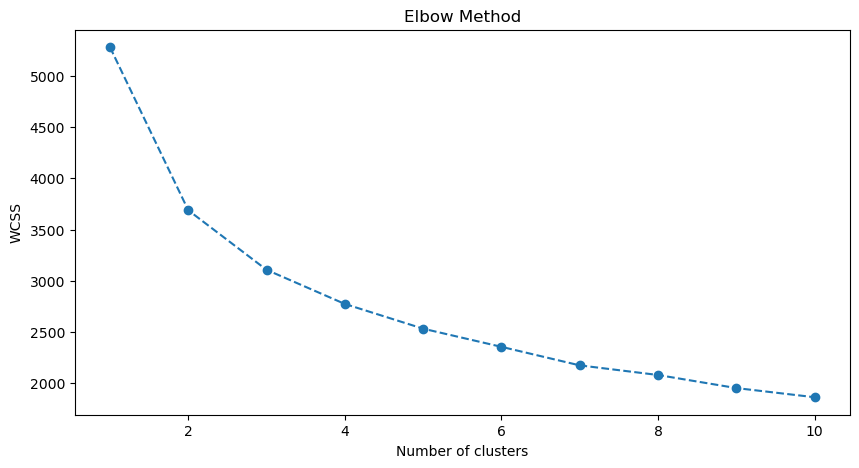

In [35]:
# Determine WCSS for a range of number of clusters
wcss = []
for i in range(1, 11):  # Let's consider 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(sales_log_transformed[columns_to_transform])
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# The curve starts to flatten out after 4 clusters. So 3 or 4 clusters.

In [33]:
kmeans = KMeans(n_clusters=3, random_state=42) 

# Fit K-Means to the scaled data, excluding the cat. 'Channel' and 'Region' columns
kmeans.fit(sales_log_transformed.drop(['Channel', 'Region'], axis=1))

sales_cs['labels'] = kmeans.labels_

sales_cs.head()

/Users/amandine/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,0


Count the values in `labels`.

In [37]:
# Your code here:

sales_cs['labels'].value_counts()

1    420
0    292
2    168
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [38]:
# Your code here

from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5)

dbscan.fit(sales_log_transformed.drop(['Channel', 'Region'], axis=1))

sales_cs['labels_DBSCAN'] = dbscan.labels_

sales_cs.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,0,-1
1,2,3,7057,9810,9568,1762,3293,1776,0,0
2,2,3,6353,8808,7684,2405,3516,7844,0,-1
3,1,3,13265,1196,4221,6404,507,1788,1,-1
4,2,3,22615,5410,7198,3915,1777,5185,0,-1


Count the values in `labels_DBSCAN`.

In [39]:
# Your code here

sales_cs['labels_DBSCAN'].value_counts()

-1    792
 5     18
 0     14
 3     14
 1     12
 4     10
 6      8
 2      6
 7      6
Name: labels_DBSCAN, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

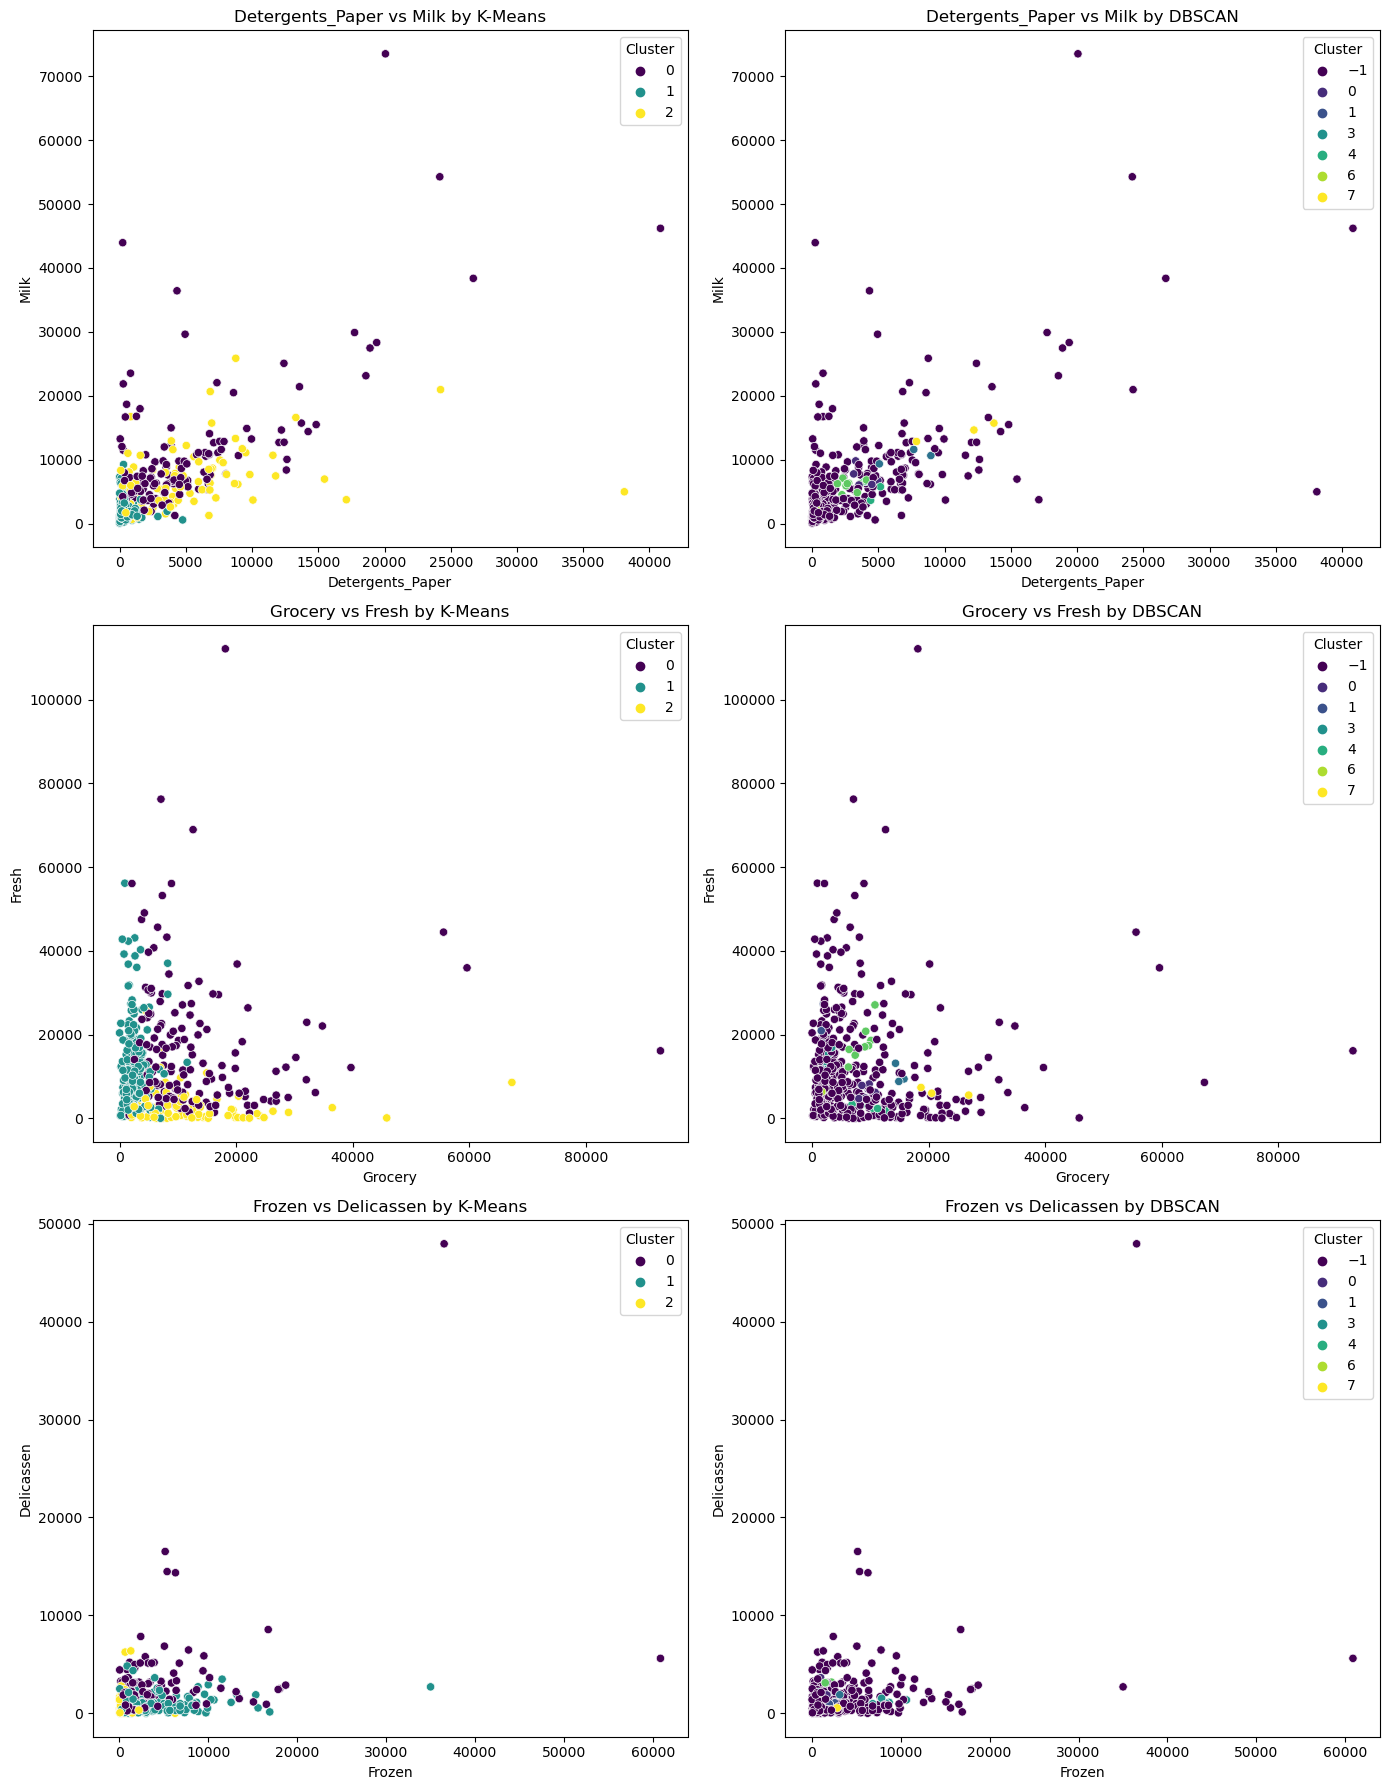

In [40]:
# Your code here:

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 18))

titles = ['K-Means', 'DBSCAN']

# Column pairs to visualize
column_pairs = [('Detergents_Paper', 'Milk'), ('Grocery', 'Fresh'), ('Frozen', 'Delicassen')]

for i, cols in enumerate(column_pairs):
    sns.scatterplot(x=cols[0], y=cols[1], hue='labels', data=sales_cs, ax=axes[i][0], palette='viridis')
    axes[i][0].set_title(f'{cols[0]} vs {cols[1]} by K-Means')
    sns.scatterplot(x=cols[0], y=cols[1], hue='labels_DBSCAN', data=sales_cs, ax=axes[i][1], palette='viridis')
    axes[i][1].set_title(f'{cols[0]} vs {cols[1]} by DBSCAN')

for ax in axes.ravel():
    ax.legend(title='Cluster')
plt.tight_layout()
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:


Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

In [ ]:
# Your code here:

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [45]:
# Your code here:

kmeans_means = sales_cs.groupby('labels').mean()

dbscan_means = sales_cs.groupby('labels_DBSCAN').mean()

print(f"Kmeans = {kmeans_means}")
print("\nMeans by DBSCAN Clustering")
print(dbscan_means)

Kmeans =          Channel    Region         Fresh          Milk       Grocery  \
labels                                                                 
0       1.609589  2.609589  17188.486301  10616.671233  13312.917808   
1       1.014286  2.495238  12006.238095   1964.038095   2480.914286   
2       1.595238  2.547619   2967.880952   6998.511905  12308.142857   

             Frozen  Detergents_Paper   Delicassen  labels_DBSCAN  
labels                                                             
0       4182.089041       4975.630137  2852.479452      -0.219178  
1       3278.000000        421.561905   896.090476      -0.676190  
2        627.202381       5391.511905   789.309524      -0.940476  

Means by DBSCAN Clustering
                Channel    Region         Fresh          Milk       Grocery  \
labels_DBSCAN                                                                 
-1             1.297980  2.545455  12061.393939   5834.383838   7981.691919   
 0             1.857143  

Which algorithm appears to perform better?

In [46]:
# Your observations here

# K means. It give more defined cluster, data are a bit more interpretable.
# Each cluster could represent a segment of customers who make a large, mid, small amount of purchase.
# Three generical category is easier to classify them:
# Cluster 1 has lower spending in Milk, Grocery, and Detergents_Paper, 
# which might represent smaller shops or cafes. 
# Cluster 2 shows high spending in Milk, Grocery, and Detergents_Paper but 
# low spending in Fresh and Frozen, possibly indicating convenience or grocery stores specializing in non-perishable items.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

/Users/amandine/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amandine/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amandine/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amandine/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/a

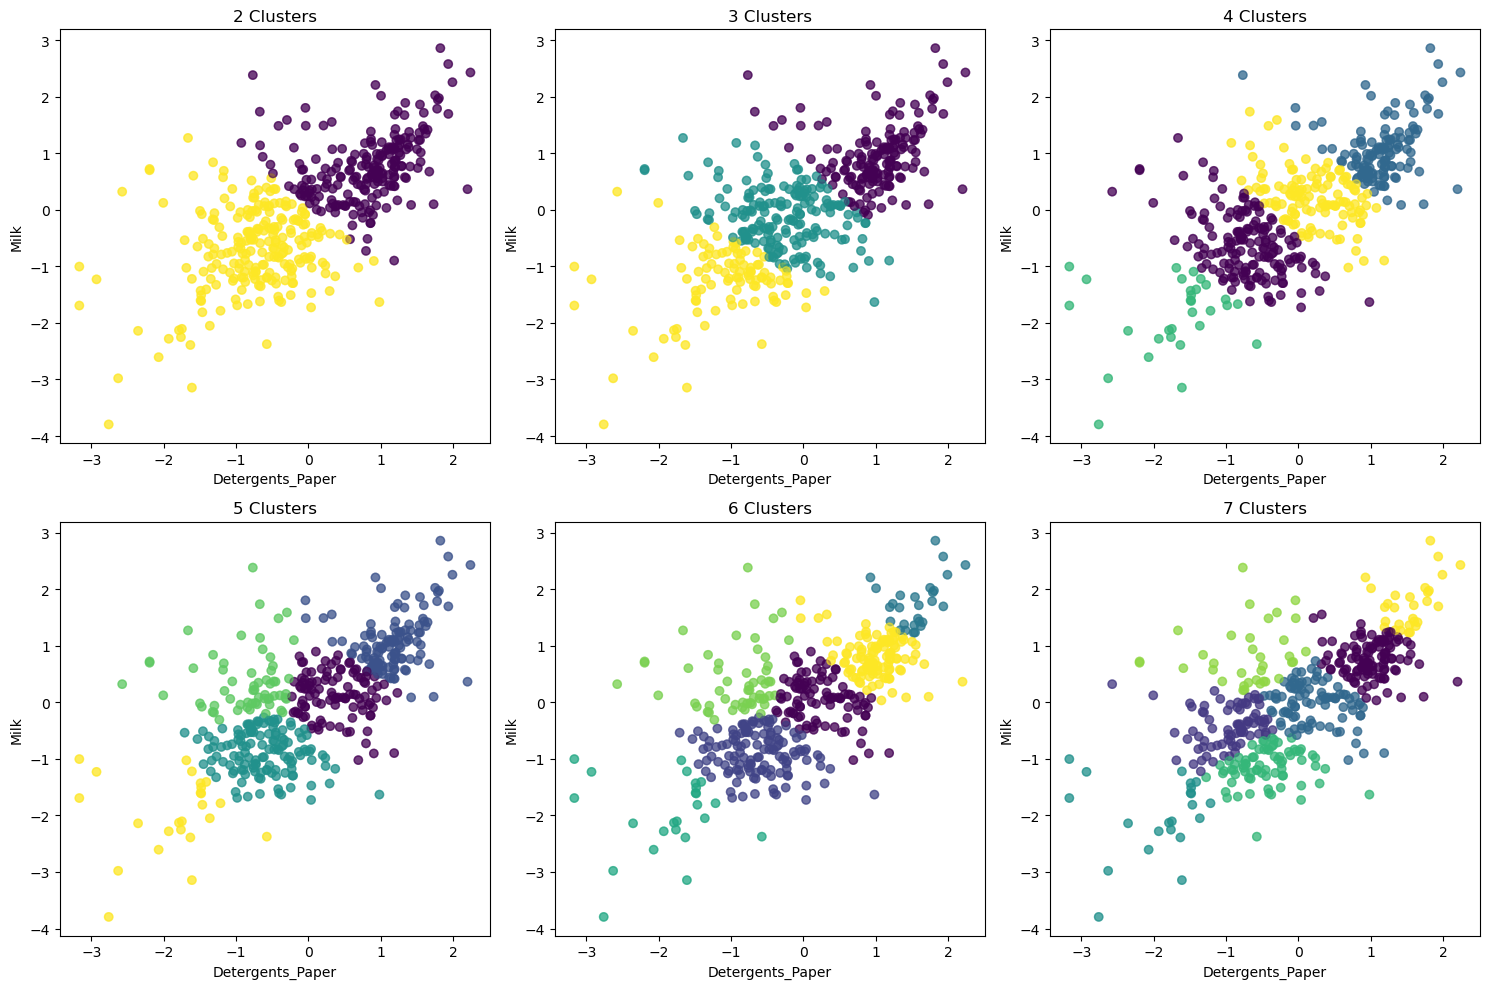

In [47]:
# Your code here

# Let's pick a column pair to visualize
x_col = 'Detergents_Paper'
y_col = 'Milk'

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.ravel()

n_clusters_options = [2, 3, 4, 5, 6, 7]

for i, n_clusters in enumerate(n_clusters_options):
  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  
    kmeans.fit(sales_log_transformed[[x_col, y_col]])
  
    labels = kmeans.labels_
    
    # Scatter plot
    axes[i].scatter(sales_log_transformed[x_col], sales_log_transformed[y_col], c=labels, cmap='viridis', alpha=0.5)
    axes[i].set_title(f'{n_clusters} Clusters')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)

plt.tight_layout()
plt.show()


In [48]:
# Your comment here

# With 3 clusters we have a clear separation, and clear shape to capture tendencies.
# Below 3, only two blocks, we can miss some info or granularity.
# Above 3, too dispearsed to capture tendencies (maybe too granular)

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

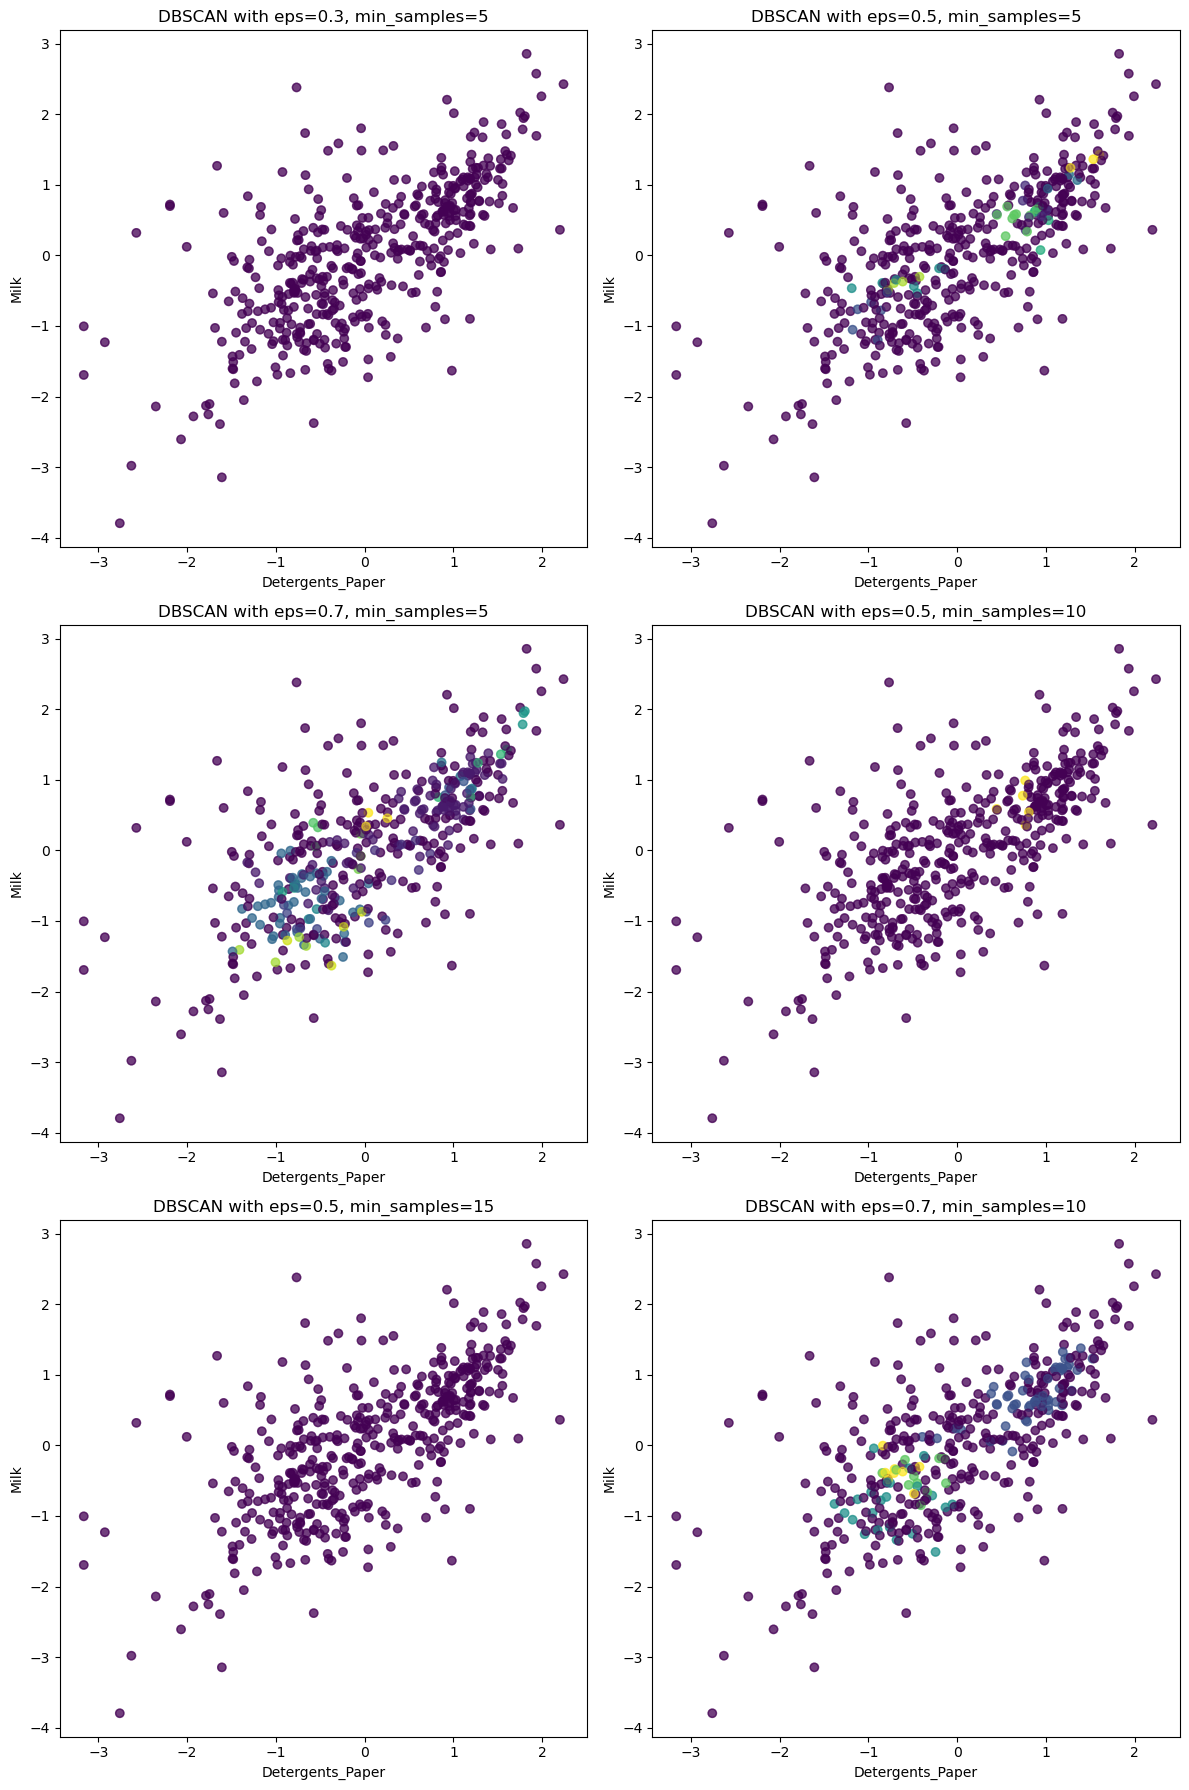

In [49]:
# Your code herefrom sklearn.cluster import DBSCAN

fig, axes = plt.subplots(3, 2, figsize=(12, 18))  
axes = axes.ravel()

params = [(0.3, 5), (0.5, 5), (0.7, 5), (0.5, 10), (0.5, 15), (0.7, 10)]

for i, (eps, min_samples) in enumerate(params):
    # Initialize DBSCAN with the current set of parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # Fit DBSCAN
    dbscan.fit(sales_log_transformed[columns_to_transform])
    # Get the cluster labels
    labels = dbscan.labels_
    
    # Scatter plot
    axes[i].scatter(sales_log_transformed['Detergents_Paper'], sales_log_transformed['Milk'], c=labels, cmap='viridis', alpha=0.5)
    axes[i].set_title(f'DBSCAN with eps={eps}, min_samples={min_samples}')
    axes[i].set_xlabel('Detergents_Paper')
    axes[i].set_ylabel('Milk')

plt.tight_layout()
plt.show()

In [50]:
# Your comment here

# DBSCAN with eps=0.3, min_samples=5: Almost all points are considered noise (no distinct clusters are visible). This setting is too restrictive, leading to an underfitting where the algorithm is unable to form clusters.
 
# DBSCAN with eps=0.5, min_samples=5: A few clusters are beginning to form, with a considerable number of points still considered noise (purple points). This setting starts to reveal the underlying structure but may still be too restrictive.

# DBSCAN with eps=0.7, min_samples=5: More clusters are forming, and fewer points are considered noise. Increasing eps allows more points to be included in clusters, which seems to capture more structure.
 
# DBSCAN with eps=0.5, min_samples=10: Increasing min_samples while keeping eps constant has resulted in more points being considered as noise compared to when min_samples=5. This setting is more conservative in forming clusters.
 
# DBSCAN with eps=0.5, min_samples=15: With even higher min_samples, the algorithm is very conservative, and most points are considered noise. This could indicate overfitting to very dense areas, missing broader structures.
 
# DBSCAN with eps=0.7, min_samples=10: This setting seems to strike a balance between forming clusters and not designating too many points as noise. There's a clear cluster structure with some noise remaining.